In [88]:
from src.data import extract_vault, holdout, delete_nodes_without_links
import matplotlib.pyplot as plt 
import networkx as nx

import markdown as md
from bs4 import BeautifulSoup
import PyPDF2

import io
from PIL import Image
import numpy as np

import torch
from transformers import BertTokenizer, BertModel, VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

from tqdm.notebook import tqdm
import pickle

from scipy import sparse
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [89]:
vault = extract_vault('./vaultes/obsidian-hub/')
# vault = extract_vault('./vaultes/brain/')

Front matter not populated for T - Thecookiemomma's Daily Log.md: ParserError('while parsing a block mapping', <yaml._yaml.Mark object at 0x7fcefd3d88b0>, 'did not find expected key', <yaml._yaml.Mark object at 0x7fcefd3d8720>)
Front matter not populated for T - Thecookiemomma's Daily Log.md: ParserError('while parsing a block mapping', <yaml._yaml.Mark object at 0x7fcee8d10590>, 'did not find expected key', <yaml._yaml.Mark object at 0x7fcee8d104f0>)
Front matter not populated for radekkozak.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7fceb84cd540>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7fcefcbe9130>)
Front matter not populated for radekkozak.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7fcefcbe9310>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7fcefcbe9ae0>)
Front matter not populated for kepano.md: ScannerError('while scanning for the nex

In [90]:
#df = brain_vault.get_all_file_metadata()
df = vault.get_all_file_metadata()
df

,rel_filepath,abs_filepath,file_exists,n_backlinks,n_wikilinks,n_tags,n_embedded_files,modified_time,graph_category
file,,,,,,,,,
,NaN,NaN,False,18,NaN,NaN,NaN,NaT,nonexistent
Mammoth,02 - Community Expansions/02.05 All Community ...,vaultes/obsidian-hub/02 - Community Expansions...,True,1,2.0,1.0,1.0,2023-03-23 23:53:17.859952927,note
JoshKasap,01 - Community/People/JoshKasap.md,vaultes/obsidian-hub/01 - Community/People/Jos...,True,2,1.0,0.0,0.0,2023-03-23 23:53:17.714100599,note
iPadOS Apps,02 - Community Expansions/02.04 Auxiliary Tool...,vaultes/obsidian-hub/02 - Community Expansions...,True,39,0.0,1.0,0.0,2023-03-23 23:53:17.773526192,note
jgauth,01 - Community/People/jgauth.md,vaultes/obsidian-hub/01 - Community/People/jga...,True,2,1.0,0.0,0.0,2023-03-23 23:53:17.741004944,note
...,...,...,...,...,...,...,...,...,...
css-obsidian-layout.png,NaN,NaN,False,1,NaN,NaN,NaN,NaT,nonexistent
01 - Community/People/hipstersmoothie,NaN,NaN,False,4,NaN,NaN,NaN,NaT,nonexistent
signynt,NaN,NaN,False,1,NaN,NaN,NaN,NaT,nonexistent


In [91]:
df.index.value_counts()

Everblush                                                                        2
g-bauer                                                                          2
signynt                                                                          2
01 - Community/People/hipstersmoothie                                            2
css-obsidian-layout.png                                                          2
                                                                                ..
01 - Community/People/petr-nazarov                                               1
02 - Community Expansions/02.05 All Community Expansions/Themes/Ultra Lobster    1
01 - Community/People/aaron-jack-manning                                         1
aosr                                                                             1
transclusions                                                                    1
Name: file, Length: 4869, dtype: int64

In [92]:
len(vault.graph.nodes)

4869

In [93]:
delete_nodes_without_links(vault.graph)

deleted 72 nodes from graph


In [94]:
len(vault.graph.nodes)

4797

In [95]:
def get_text_from_html(html):
    soup = BeautifulSoup(html, features="html.parser")

    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out

    # get text
    text = soup.get_text()

    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    return text

def get_text_from_markdown(filepath):
    with open(filepath, 'r') as f:
        text = f.read()
        html = md.markdown(text)
        text = get_text_from_html(html)
    return text

def get_text_from_pdf(filepath):
    with open(filepath, 'rb') as f:
        pdfReader = PyPDF2.PdfReader(f)
        text = ""
        
        for page in pdfReader.pages:
            text += page.extract_text()
            all_images.extend(page.images)
    return text


def get_images_from_pdf(filepath):
    with open(filepath, 'rb') as f:
        pdfReader = PyPDF2.PdfReader(f)
        images = []
        
        for page in pdfReader.pages:
            for image_file in page.images:
                images.append(Image.open(io.BytesIO(image_file.data)))
    return images

In [96]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer_bert = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model_bert = BertModel.from_pretrained("bert-base-multilingual-cased")

model_bert.to(device)

1

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1

In [97]:
# model_i2t = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# tokenizer_i2t = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# model_i2t.to(device)

# 1

In [98]:
@torch.no_grad()
def encode_text(text):
    encoded_input = tokenizer_bert(text, truncation=True, return_tensors='pt')
    output = model_bert(**encoded_input)
    return output.pooler_output.cpu().numpy()[0]

In [99]:
# def image_to_text(image):
#     if image.mode != "RGB":
#         image = image.convert(mode="RGB")
    
#     pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values
#     pixel_values = pixel_values.to(device)

#     gen_kwargs = {"max_length": 256, "num_beams": 4}
#     output_ids = model_i2t.generate(pixel_values, **gen_kwargs)

#     preds = tokenizer_i2t.batch_decode(output_ids, skip_special_tokens=True)
#     preds = [pred.strip() for pred in preds]
#     return preds[0]

In [100]:
# embeddings = []

# for path in tqdm(df["abs_filepath"]):
#     extension = str(path).split('.')[-1]
#     if extension == 'md':
#         text = get_text_from_markdown(path)
#         embeddings.append(encode_text(text))
#     elif extension == 'pdf':
#         text = get_text_from_pdf(path)
#         images = get_images_from_pdf(path)
#         for image in tqdm(images, desc='images', leave=False):
#             text += " "
#             text += image_to_text(image)
#         embeddings.append(encode_text(text))
#     elif extension in {'jpeg', 'gif', 'png'}:
#         image = Image.open(path)
#         text = image_to_text(image)
#         embeddings.append(encode_text(text))
#     else:
#         # embeddings.append(np.random.rand(768))
#         1/0

In [101]:
embeddings = []

for text in tqdm(vault.graph.nodes):
    embeddings.append(encode_text(text))

  0%|          | 0/4797 [00:00<?, ?it/s]


KeyboardInterrupt



In [67]:
emb_dict = {}

for file, emb in zip(vault.graph.nodes, embeddings):
    emb_dict[file] = emb

with open("brain_embeddings.pkl", 'wb') as f:
    pickle.dump(emb_dict, f)

# LightFM part

In [102]:
from lfm import build_lfm_model
from evaluation import topn_recommendations, downvote_seen_items

In [103]:
# your code here
def cartesian_product(x, y):
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def lightfm_scoring(model, data, data_description, item_bias=True):
    users = np.unique(data_description['users'])
    items = np.arange(data_description['n_items'])
    
    user_item_pairs = cartesian_product(users, items)
    
    if item_bias is False:
        cur_biases = lfm_model.item_biases.copy()

        lfm_model.item_biases *= 0
    
    predictions = model.predict(
                                user_ids=user_item_pairs[:, 0],
                                item_ids=user_item_pairs[:, 1],
                                user_features=data_description['user_features'],
                                item_features=data_description['item_features'],
                               )
    scores = predictions.reshape(len(items), len(users))
    
    if item_bias is False:
        lfm_model.item_biases[:] = cur_biases
    
    return scores.T, users

In [104]:
def recall(lfm_recs, users, del_edges, holdout_data_description):
    
    edges_dict = {}
    
    for edge in del_edges:
        edges_dict[edge[0]] = edges_dict.get(edge[0], set())
        edges_dict[edge[0]].add(edge[1])
    
    metric = 0
    
    for i, rec in enumerate(lfm_recs):
        metric += len(set(rec) & edges_dict[users[i]]) / len(edges_dict[users[i]])
    
    return metric / len(users)

In [107]:
recalls = []

alpha = 0.2
topn = 20
tries = 1


for _ in tqdm(range(tries)):
    modified_graph, deleted_edges = holdout(vault.graph, alpha=alpha)
    
    del_edges = []

    for edge in deleted_edges:
        ind0 = list(vault.graph.nodes).index(edge[0])
        ind1 = list(vault.graph.nodes).index(edge[1])
        del_edges.append((ind0, ind1))
    
    train_matrix = nx.adjacency_matrix(modified_graph)
    data_description = dict(
        n_users = train_matrix.shape[0],
        n_items = train_matrix.shape[1],
        # user_features = ... skip for now, will be defined later
        # item_features = None # compound features are not present in the dataset
    )
    
    with open("obsidian_embeddings.pkl", 'rb') as f:
        emb_dict = pickle.load(f)
    
    data_description["user_features"] = sparse.csr_matrix([emb_dict[file] for file in vault.graph.nodes])
    data_description["item_features"] = sparse.csr_matrix([emb_dict[file] for file in vault.graph.nodes])
    
    holdout_data_description = dict(
        users = [de_[0] for de_ in del_edges],
        n_items = train_matrix.shape[1],
        # user_features = ... skip for now, will be defined later
        # item_features = None # compound features are not present in the dataset
    )
    
    holdout_data_description["user_features"] = sparse.csr_matrix([emb_dict[file] for file in vault.graph.nodes])
    holdout_data_description["item_features"] = sparse.csr_matrix([emb_dict[file] for file in vault.graph.nodes])
    
    lfm_config = dict(
        no_components = 256,
        loss = 'warp',
        max_sampled = 1,
        max_epochs = 30,
        learning_schedule = 'adagrad',
        user_alpha = 1e-3,
        item_alpha = 1e-3,
        random_state = 7032023
    )
    
    lfm_model = build_lfm_model(
        lfm_config,
        train_matrix,
        data_description,
        iterator=tqdm
    )
    
    lfm_scores, test_users = lightfm_scoring(lfm_model, None, holdout_data_description, item_bias=False)
    for j, user in enumerate(test_users):
        for i, check in enumerate(train_matrix.toarray()[user]):
            if check == 1.0:
                lfm_scores[j, i] = lfm_scores.min() - 1
            
    # downvote_seen_items(lfm_scores, train_matrix, data_description)
    lfm_recs = topn_recommendations(lfm_scores, topn=topn)
    
    
    recalls.append(recall(lfm_recs, test_users, del_edges, holdout_data_description))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [108]:
print(np.mean(recalls))

0.1573980865522956


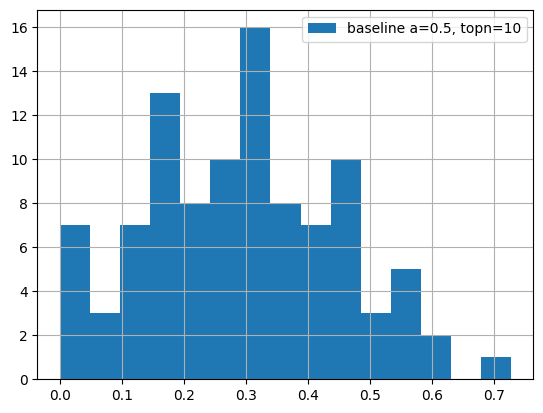

In [86]:
fig, ax = plt.subplots(1)
hist = pd.DataFrame(recalls).hist(bins=15, ax=ax, label=f'baseline a={alpha}, topn={topn}')
ax.legend(loc='best')
ax.set_title('')
plt.savefig(f'./results/lightfm/alpha={alpha}_topn={topn}_n_exp={tries}_vault=brain.png', dpi=300)